 ## What does this code do?



 We compute simple returns $ r_{ji} = P_{ji} - P_{j, i-1} $  for the $j$-th market at interval $i$.



 Because prices can be zero or negative, log returns are not applicable.



 Following Andersen et al. (2001) and Bollerslev et al. (2020), we estimate the realized daily variation and covariation using the covariance matrix definition:


$$
\text{ReCov} = \sum_{i=1}^m r_i r_i' = 
\begin{bmatrix}
\text{ReVar}_{FR} & \text{ReCov}_{FR-ES} & \text{ReCov}_{FR-PT} \\
\text{ReCov}_{ES-FR} & \text{ReVar}_{ES} & \text{ReCov}_{ES-PT} \\
\text{ReCov}_{PT-FR} & \text{ReCov}_{PT-ES} & \text{ReVar}_{PT}
\end{bmatrix}
$$




 To prepare for the multivariate HAR (MHAR) model (Corsi, 2009), we apply a **variance stabilizer** based on the Probability Integral Transform (PIT) following Uniejewski et al. (2017):

 $$

 Z_t = G^{-1}(\hat{F}(X_t))

 $$

 where $X_t$ is the realized measure, $\hat{F}$ its estimated CDF, and $G^{-1}$ the inverse standard normal CDF.



 This transformation is used to approximate normality of the realized measures, which is important for the generalized variance decomposition step.

 ## Step 1: Load data and handle DST duplicates

In [16]:
# Import libraries

import pandas as pd
import numpy as np
from scipy.stats import norm
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered data
df = pd.read_parquet("parquet_files/filtered_data.parquet")

# Sort and disambiguate duplicated timestamps caused by DST
df = df.sort_values(['Area', 'Start DateTime'])
df['dup_rank'] = df.groupby(['Area', 'Start DateTime']).cumcount()
df['Start DateTime Unique'] = df['Start DateTime'] + pd.to_timedelta(df['dup_rank'], unit='s')

# Pivot to get prices in wide format (rows = times, columns = markets)
df_pivot = df.pivot(index='Start DateTime Unique', columns='Area', values='Day-ahead Price (EUR/MWh)').sort_index()
df_pivot.head(5)


Area,BZN|ES,BZN|FR,BZN|PT
Start DateTime Unique,,,
2021-05-21 00:00:00,80.85,37.24,80.85
2021-05-21 01:00:00,79.46,22.90,79.46
2021-05-21 02:00:00,79.18,14.29,79.18
2021-05-21 03:00:00,79.18,7.83,79.18
2021-05-21 04:00:00,79.46,7.08,79.46


 ## Step 2: Compute simple returns

In [17]:
# Calculate simple returns: \(r_{ji} = P_{ji} - P_{j,i-1}\)
simple_returns = df_pivot.diff().dropna()
simple_returns.head(5)


Area,BZN|ES,BZN|FR,BZN|PT
Start DateTime Unique,,,
2021-05-21 01:00:00,-1.39,-14.34,-1.39
2021-05-21 02:00:00,-0.28,-8.61,-0.28
2021-05-21 03:00:00,0.00,-6.46,0.00
2021-05-21 04:00:00,0.28,-0.75,0.28
2021-05-21 05:00:00,-0.28,9.61,-0.28


 ## Step 3: Calculate daily realized covariance matrices

In [18]:
# Add date column to group by day
simple_returns['Date'] = simple_returns.index.date

# Prepare a dict to store daily covariance DataFrames
daily_covariances = {}

# Loop through each day to compute daily realized covariance matrices
for day, group in simple_returns.groupby('Date'):
    returns_only = group.drop(columns='Date')
    cov_matrix = np.zeros((returns_only.shape[1], returns_only.shape[1]))
    for i in range(returns_only.shape[0]):
        r = returns_only.iloc[i].values.reshape(-1, 1)
        cov_matrix += r @ r.T
    daily_covariances[day] = pd.DataFrame(cov_matrix, index=returns_only.columns, columns=returns_only.columns)


In [19]:
# Print the first day covariance matrix
first_key, first_value = next(iter(daily_covariances.items()))
print(first_key)
print(first_value)

2021-05-21
Area      BZN|ES     BZN|FR    BZN|PT
Area                                 
BZN|ES  900.7055   610.1282  849.2810
BZN|FR  610.1282  3308.8123  396.1419
BZN|PT  849.2810   396.1419  856.6119


 ## Step 4: Apply variance stabilizer (PIT transformation) to daily realized variances

In [20]:
# Extract realized variances (diagonal of daily covariance matrices) into a DataFrame
daily_vars = pd.DataFrame(
    {
        day: pd.Series(np.diag(cov), index=cov.index)  # Use cov.index as labels for diagonal
        for day, cov in daily_covariances.items()
    }
).T  # transpose to have days as rows

daily_vars.index = pd.to_datetime(daily_vars.index)

print(daily_vars)


Area            BZN|ES      BZN|FR     BZN|PT
2021-05-21    900.7055   3308.8123   856.6119
2021-05-22    638.1532   2775.8191   638.1532
2021-05-23    787.1981   3423.8128   787.1981
2021-05-24    865.9875   3088.8052   865.9875
2021-05-25    262.7337   1546.6911   245.3007
...                ...         ...        ...
2025-04-26   1071.2846   6671.9574  1071.2846
2025-04-27   7724.2352   9004.9724  7719.7434
2025-04-28   5961.1488  12618.8822  5516.0066
2025-04-29   1936.0119   6757.8290  1936.0119
2025-04-30  18586.3441  19642.8713   773.1457

[1441 rows x 3 columns]


C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


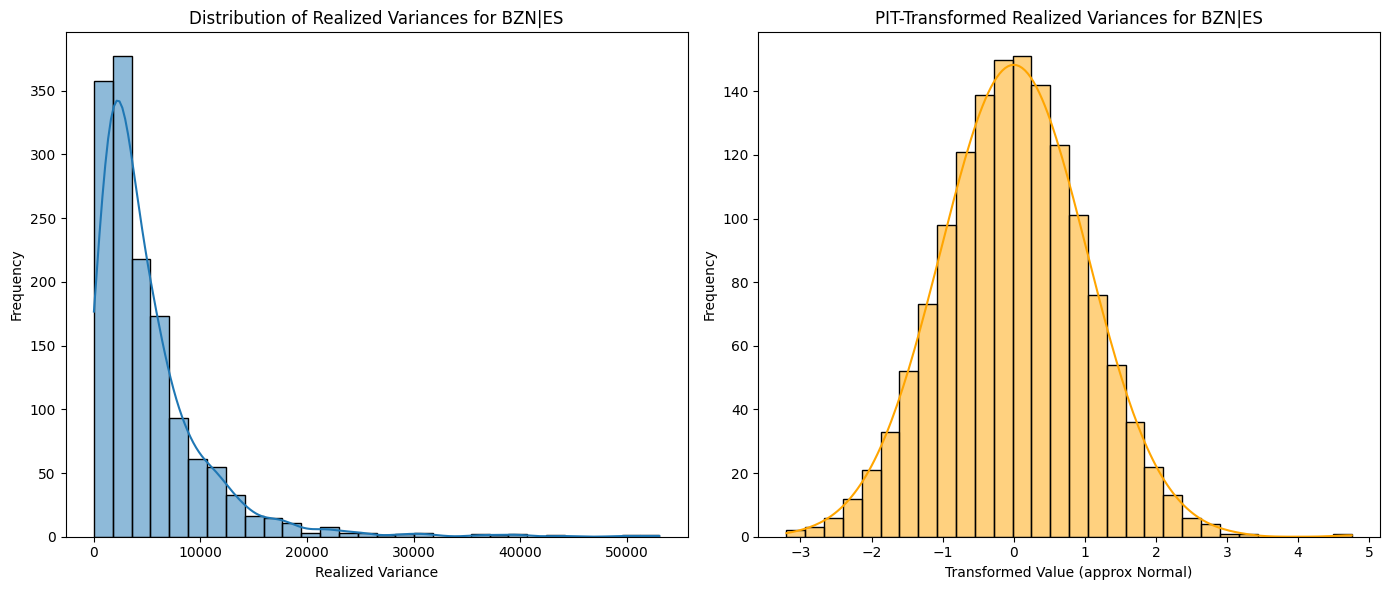

In [21]:
# Estimate the empirical cumulative distribution function (CDF) for each market's realized variances
# and apply the Probability Integral Transform (PIT) to stabilize variance and achieve approximate normality.
#
# The PIT is performed by:
# 1. Sorting the data to estimate the empirical CDF values for each observation.
# 2. Using these CDF values as inputs to the inverse standard normal CDF (norm.ppf),
#    which transforms the data to follow an approximately standard normal distribution.
#
# Clipping the CDF values avoids issues with extreme 0 or 1 probabilities, which would
# lead to infinite values after the inverse normal transform.

def pit_transform(x):
    sorted_x = np.sort(x)
    cdf_vals = np.searchsorted(sorted_x, x, side='right') / len(x)
    # Avoid exact 0 or 1 for norm.ppf by clipping
    cdf_vals = np.clip(cdf_vals, 1e-6, 1-1e-6)
    return norm.ppf(cdf_vals)

pit_vars = daily_vars.apply(pit_transform, axis=0)

# Plot distributions before and after PIT transform for a selected market
market = daily_vars.columns[0]  # choose the first market as example

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(daily_vars[market], bins=30, kde=True)
plt.title(f'Distribution of Realized Variances for {market}')
plt.xlabel('Realized Variance')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(pit_vars[market], bins=30, kde=True, color='orange')
plt.title(f'PIT-Transformed Realized Variances for {market}')
plt.xlabel('Transformed Value (approx Normal)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



 ## Step 5: Save outputs for modeling

In [22]:
# Save simple returns (without Date column)
simple_returns.drop(columns='Date').to_parquet("parquet_files/simple_returns.parquet")

# Save daily realized covariance matrices as a single parquet with MultiIndex (day + market pairs)
# Flatten daily covariance matrices into long format for storage
records = []
for day, cov in daily_covariances.items():
    for i, mkt1 in enumerate(cov.index):
        for j, mkt2 in enumerate(cov.columns):
            records.append({'Date': day, 'Market1': mkt1, 'Market2': mkt2, 'Value': cov.iloc[i,j]})

daily_cov_long = pd.DataFrame(records)
daily_cov_long.to_parquet("parquet_files/daily_realized_covariances.parquet")

# Save PIT-transformed variances
pit_vars.to_parquet("parquet_files/pit_transformed_variances.parquet")


In [23]:
pit_vars

Area,BZN|ES,BZN|FR,BZN|PT
2021-05-21,-1.228412,-0.469873,-1.221048
2021-05-22,-1.374370,-0.681604,-1.352340
2021-05-23,-1.322559,-0.425643,-1.289900
2021-05-24,-1.239586,-0.541040,-1.210123
2021-05-25,-1.747794,-1.202919,-1.747794
...,...,...,...
2025-04-26,-1.111202,0.257660,-1.082629
2025-04-27,0.859605,0.573548,0.935061
2025-04-28,0.579711,0.854582,0.528997
2025-04-29,-0.608767,0.273879,-0.565366
